- 버퍼 관리자의 작동 방식을 설명
- 백엔드 프로세스가 원하는 페이지에 액세스하려고 하면 ReadBufferExtended() 함수를 호출

- ReadBufferExtended() 함수의 동작은 세 가지 논리적 사례에 따라 달라짐.
- 각 사례는 다음 하위 섹션에 설명되어 있음.
- 또한 PostgreSQL 시계 스윕 페이지 교체 알고리즘은 마지막 하위 섹션에 설명되어 있음

# **Accessing a Page Stored in the Buffer Pool**

- 먼저, 원하는 페이지가 이미 버퍼 풀에 저장되어 있는 가장 간단한 경우를 설명.

**버퍼 관리자는 다음 단계를 수행**

1. 원하는 페이지의 buffer_tag를 생성하고(이 예에서는 buffer_tag가 'Tag_C'임) 해시 함수를 사용하여 생성된 buffer_tag와 관련된 항목이 포함된 해시 버킷 슬롯을 계산.

2. 공유 모드에서 획득한 해시 버킷 슬롯을 포함하는 BufMappingLock 파티션을 획득(이 잠금은 (5) 단계에서 해제됨).

3. 태그가 'Tag_C'인 항목을 찾아 해당 항목에서 buffer_id를 얻음.
  - 이 예에서 buffer_id는 2.

4. buffer_id 2에 대한 버퍼 설명자를 고정하고 설명자의 refcount 및 Usage_count를 1씩 늘림.

5. BufMappingLock을 해제.

6. buffer_id 2로 버퍼 풀 슬롯에 액세스.



**Accessing a page stored in the buffer pool.**

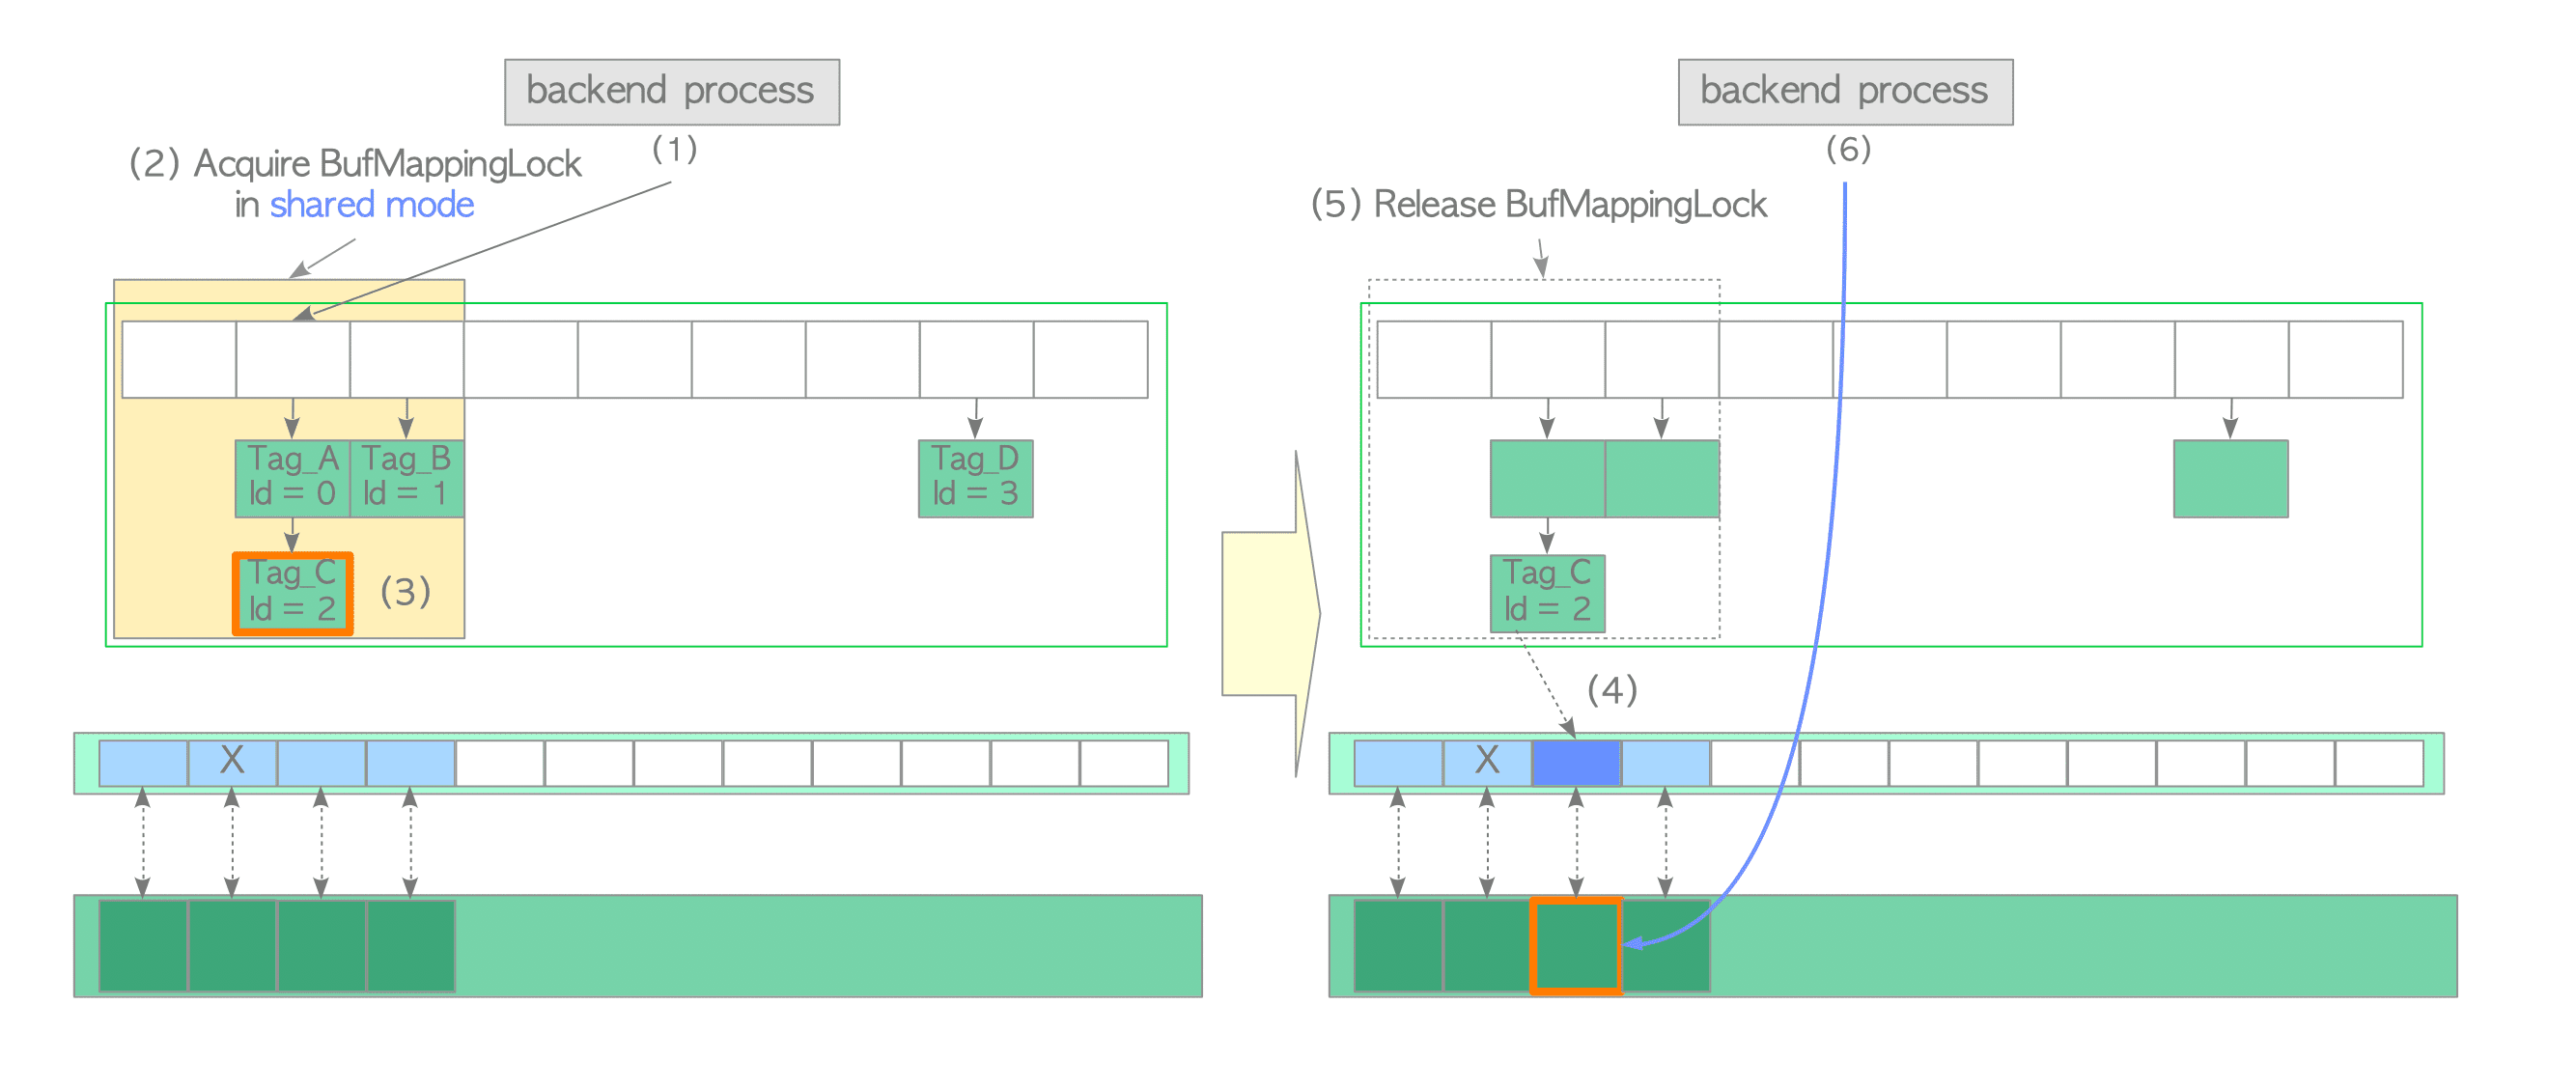

- 그런 다음 버퍼 풀 슬롯의 페이지에서 행을 읽을 때 PostgreSQL 프로세스는 해당 버퍼 설명자의 공유 content_lock을 획득
- 따라서 버퍼 풀 슬롯은 여러 프로세스에서 동시에 읽을 수 있음.

- 페이지에 행을 삽입(및 업데이트 또는 삭제)할 때 Postgres 프로세스는 해당 버퍼 설명자의 독점적인 content_lock을 획득. (페이지의 더티 비트는 1로 설정 되어야 함.)

- 페이지에 액세스한 후 해당 버퍼 설명자의 참조 횟수 값이 1씩 감소

# **Loading a Page from Storage to Empty Slot**

- 두 번째 경우에는 원하는 페이지가 버퍼 풀에 없고 freelist에 사용 가능한 요소(빈 설명자)가 있다고 가정

**버퍼 관리자는 다음 단계를 수행**

1. 버퍼 테이블을 찾음. (찾지 못한 것으로 가정.)
  1. 원하는 페이지의 buffer_tag를 생성하고(이 예에서는 buffer_tag가 'Tag_E'임) 해시 버킷 슬롯을 계산.
  2. 공유 모드에서 BufMappingLock 파티션을 획득.
  3. 버퍼 테이블을 찾아보기. (가정에 따르면 발견되지 않음.)
  4. BufMappingLock을 해제.

2. freelist에서 빈 버퍼 설명자를 얻고 이를 고정.
  - 이 예에서 획득된 설명자의 buffer_id는 4.

3. Exclusive 모드 에서 BufMappingLock 파티션을 획득 . (이 잠금은 (6)단계에서 해제됨.)

4. buffer_tag 'Tag_E'와 buffer_id 4로 구성된 새 데이터 항목을 생성.
  - 생성된 항목을 버퍼 테이블에 삽입.

5. 원하는 페이지 데이터를 스토리지에서 buffer_id 4인 버퍼 풀 슬롯에 다음과 같이 로드.
  1. 9.5 이하 버전에서는 해당 설명자의 독점적인 io_in_progress_lock을 획득.
  2. 다른 프로세스의 액세스를 방지하려면 해당 설명자의 io_in_progress 비트를 1로 설정 .
  3. 원하는 페이지 데이터를 스토리지에서 버퍼 풀 슬롯으로 로드.
  4. 해당 설명자의 상태를 변경. io_in_progress 비트는 0으로 설정되고 유효한 비트는 1로 설정됨.
  5. 버전 9.5 이하에서는 io_in_progress_lock 을 해제해야함.

6. BufMappingLock을 해제.

7. buffer_id 4로 버퍼 풀 슬롯에 액세스.

**Loading a page from storage to an empty slot.**


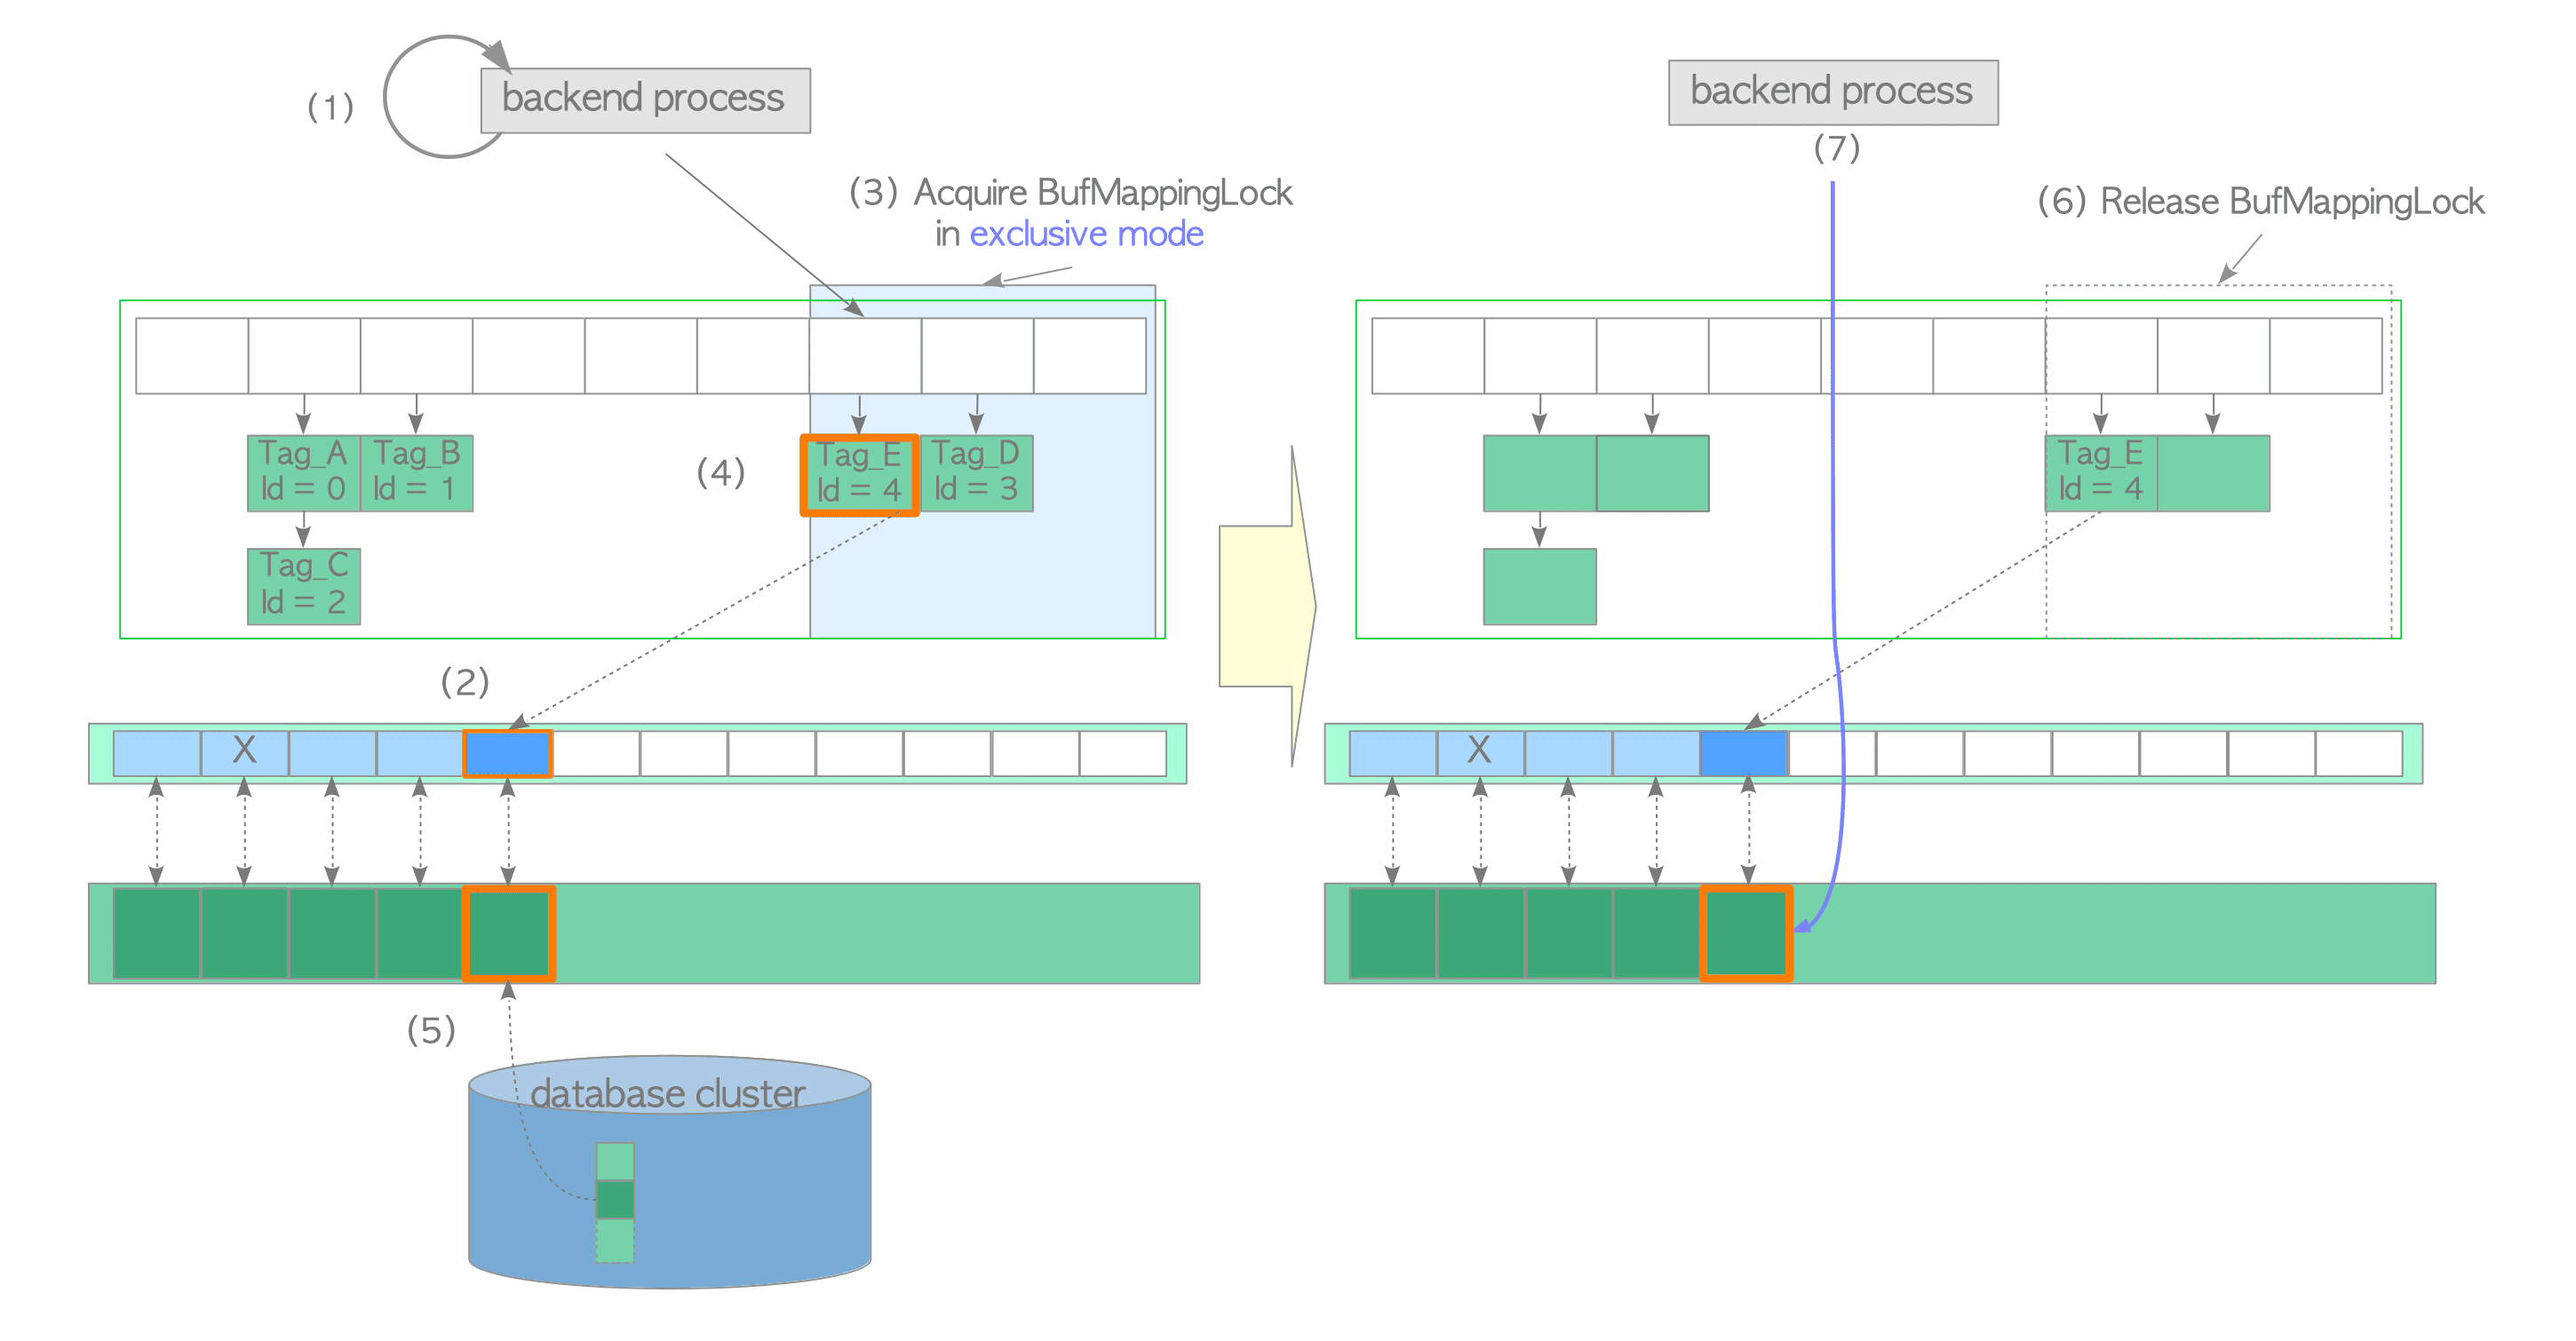

# **Loading a Page from Storage to a Victim Buffer Pool Slot**

- 이 경우 모든 버퍼 풀 슬롯을 페이지가 차지하고 있지만 원하는 페이지가 저장되지 않았다고 가정

**버퍼 관리자는 다음 단계를 수행**

1.원하는 페이지의 buffer_tag를 생성하고 버퍼 테이블을 조회.
  - 이 예에서는 buffer_tag가 'Tag_M'(원하는 페이지를 찾을 수 없음)이라고 가정.

2. clock-sweep 알고리즘을 사용하여 희생 버퍼 풀 슬롯을 선택.
  - 버퍼 테이블에서 피해자 풀 슬롯의 buffer_id가 포함된 이전 항목을 획득하고 피해자 풀 슬롯을 버퍼 설명자 레이어에 고정.
  - 이 예에서 희생 슬롯의 buffer_id는 5이고 이전 항목은 'Tag_F, id=5'.

3. 피해자 페이지 데이터가 더러워지면 플러시(쓰기 및 fsync).
  - 그렇지 않으면 (4)단계로 진행.
  - 새 데이터로 덮어쓰기 전에 더티 페이지를 스토리지에 기록해야 함.
  - 더티 페이지 플러시는 다음과 같이 수행됨.
    1. buffer_id 5(6단계에서 해제됨)를 사용하여 설명자의 공유 content_lock 및 배타적 io_in_progress 잠금을 획득.
    2. 해당 설명자의 상태를 변경. io_in_progress 비트 는 1로 설정되고 just_dirtied 비트는 0으로 설정됨.
    3. 상황에 따라 XLogFlush()함수가 호출되어 WAL 버퍼에 있는 WAL 데이터를 현재 WAL 세그먼트 파일에 기록.
    4. 피해자 페이지 데이터를 저장소로 플러시.
    5. 해당 설명자의 상태를 변경. io_in_progress 비트 는 0으로 설정되고 유효한 비트는 1로 설정됨.
    6. io_in_progress 및 content_lock 잠금을 해제.

4. 배타 모드에서 이전 항목이 포함된 슬롯을 덮는 이전 BufMappingLock 파티션을 획득.

5. 새 BufMappingLock 파티션을 획득하고 버퍼 테이블에 새 항목을 삽입.

- 새로운 buffer_tag 'Tag_M'과 피해자의 buffer_id로 구성된 새 항목을 만듬.

- 단독 모드에서 새 항목이 포함된 슬롯을 덮는 새 BufMappingLock 파티션을 획득.
- 버퍼 테이블에 새 항목을 삽입.

**Loading a page from storage to a victim buffer pool slot.**

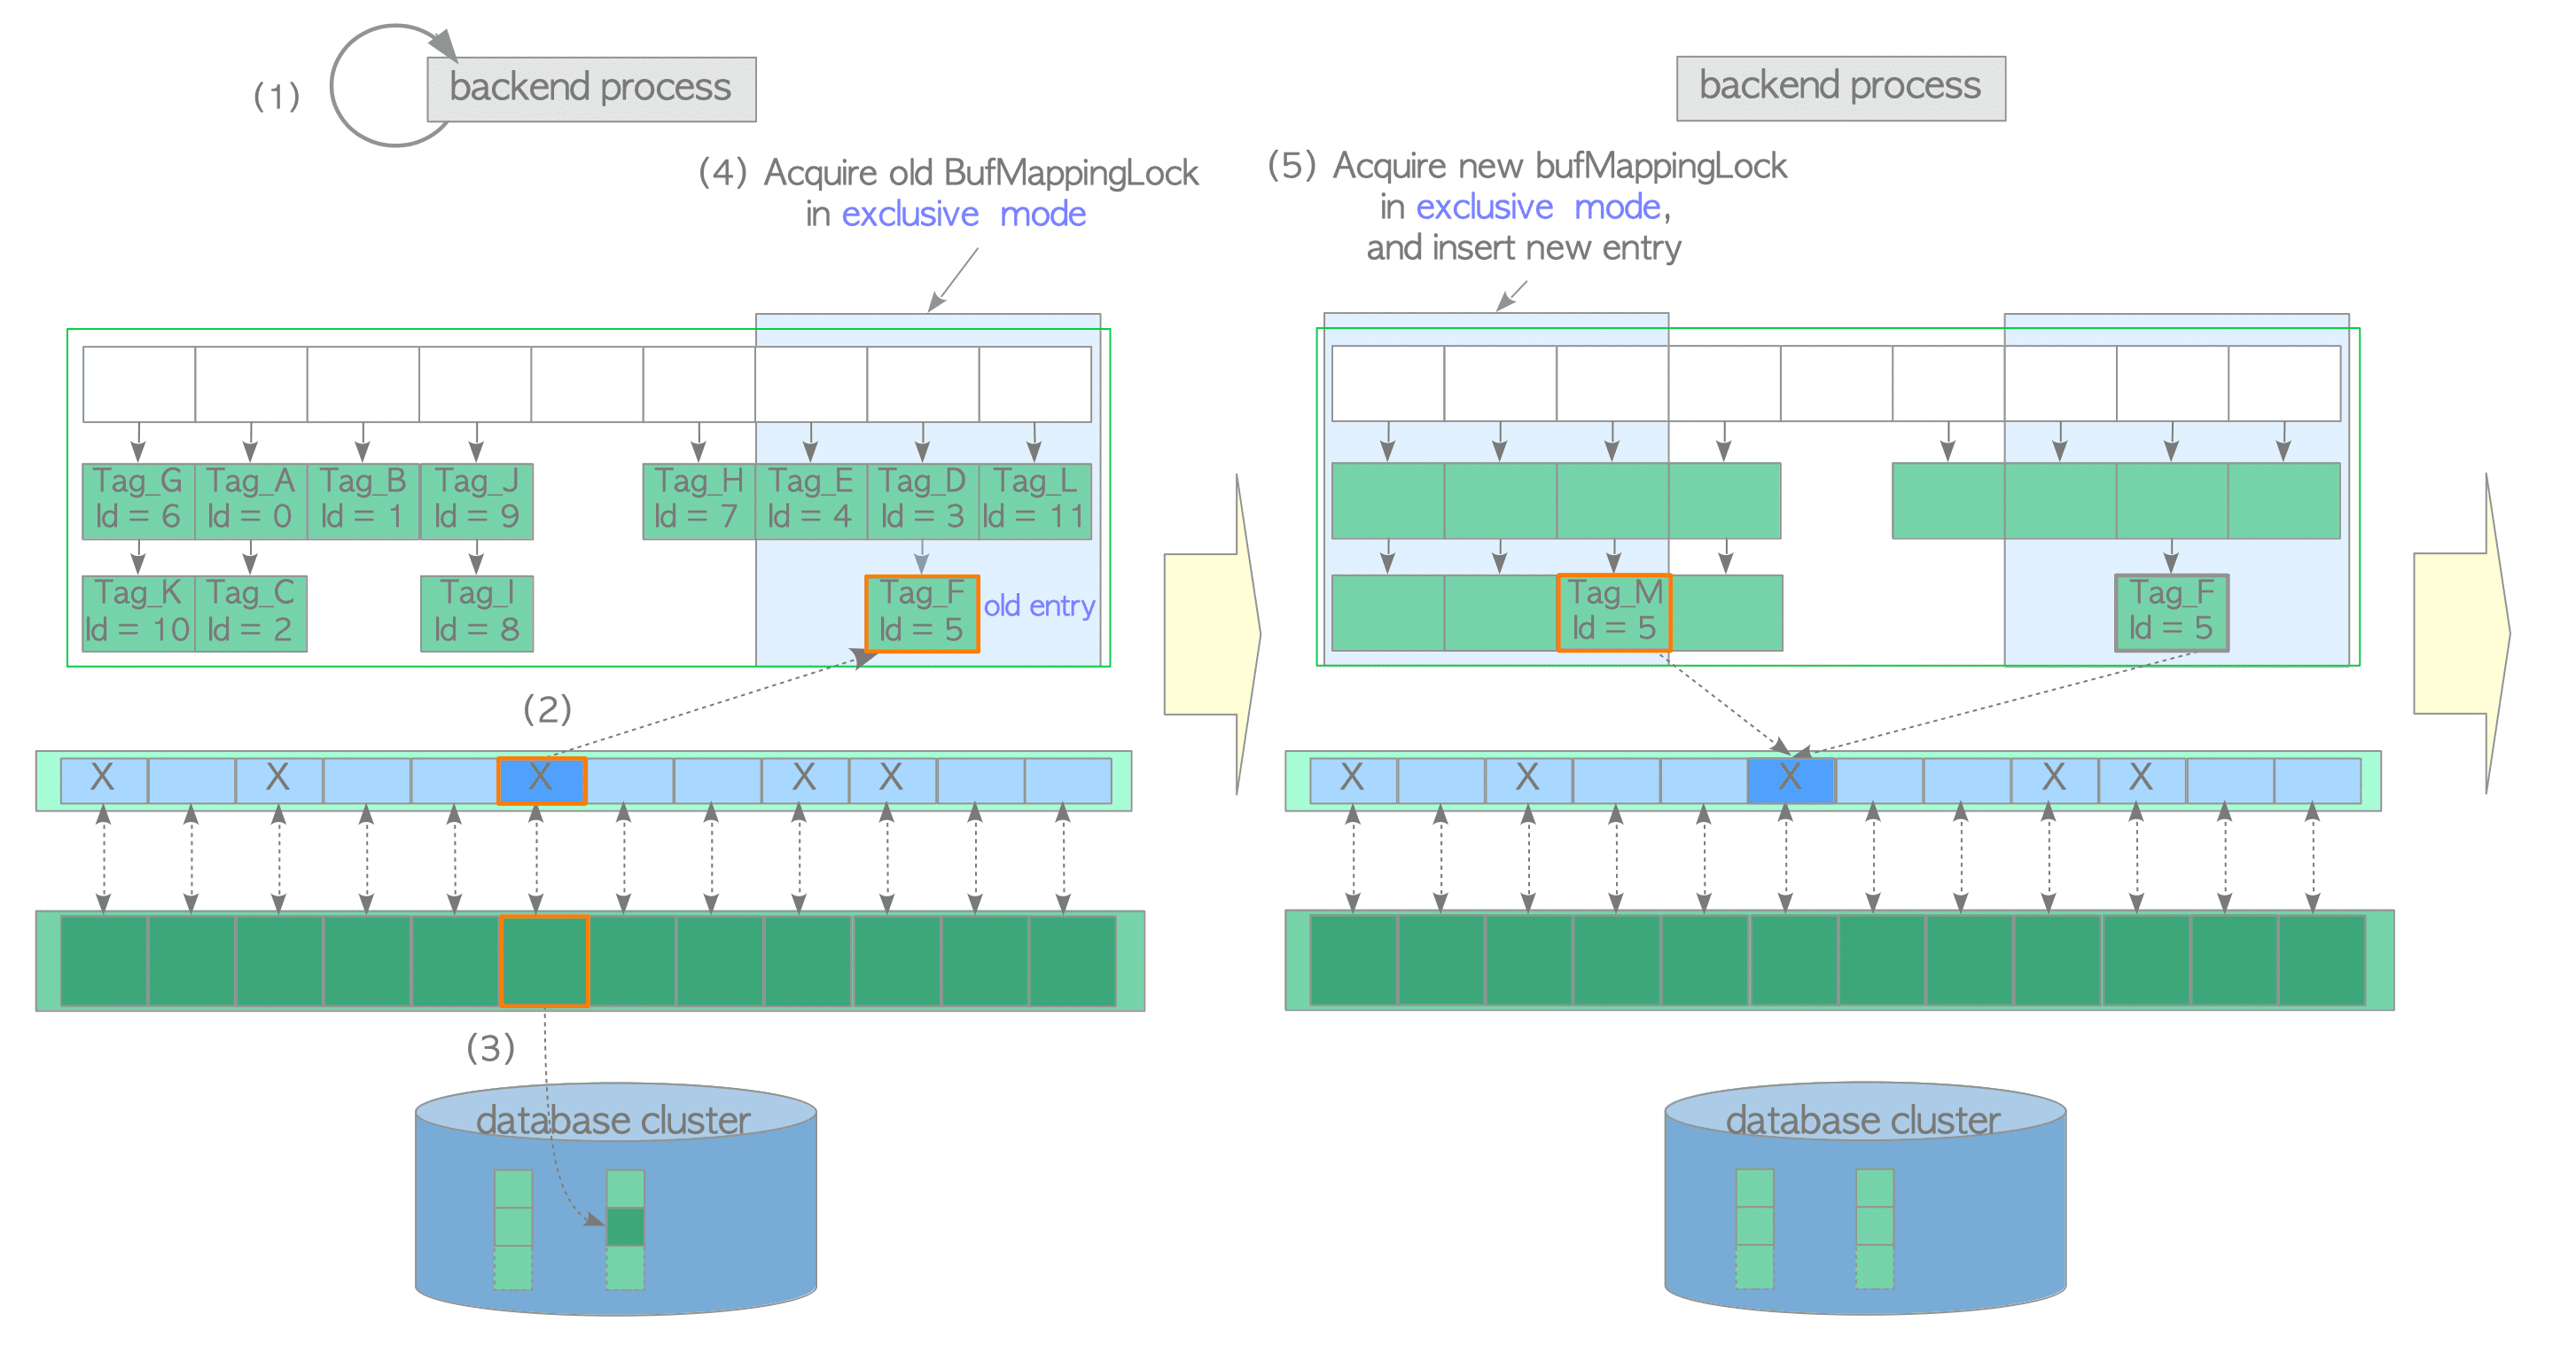

6. 버퍼 테이블에서 이전 항목을 삭제하고 이전 BufMappingLock 파티션을 해제.

7. 스토리지에서 원하는 페이지 데이터를 희생 버퍼 슬롯에 로드.
  - 그런 다음 설명자의 플래그를 buffer_id 5로 업데이트.
  - 더티 비트는 0으로 설정되고 다른 비트는 초기화.

8. 새로운 BufMappingLock 파티션을 해제.

9. buffer_id 5로 버퍼 풀 슬롯에 액세스.

**Loading a page from storage to a victim buffer pool slot (continued from Fig. 8.10).**

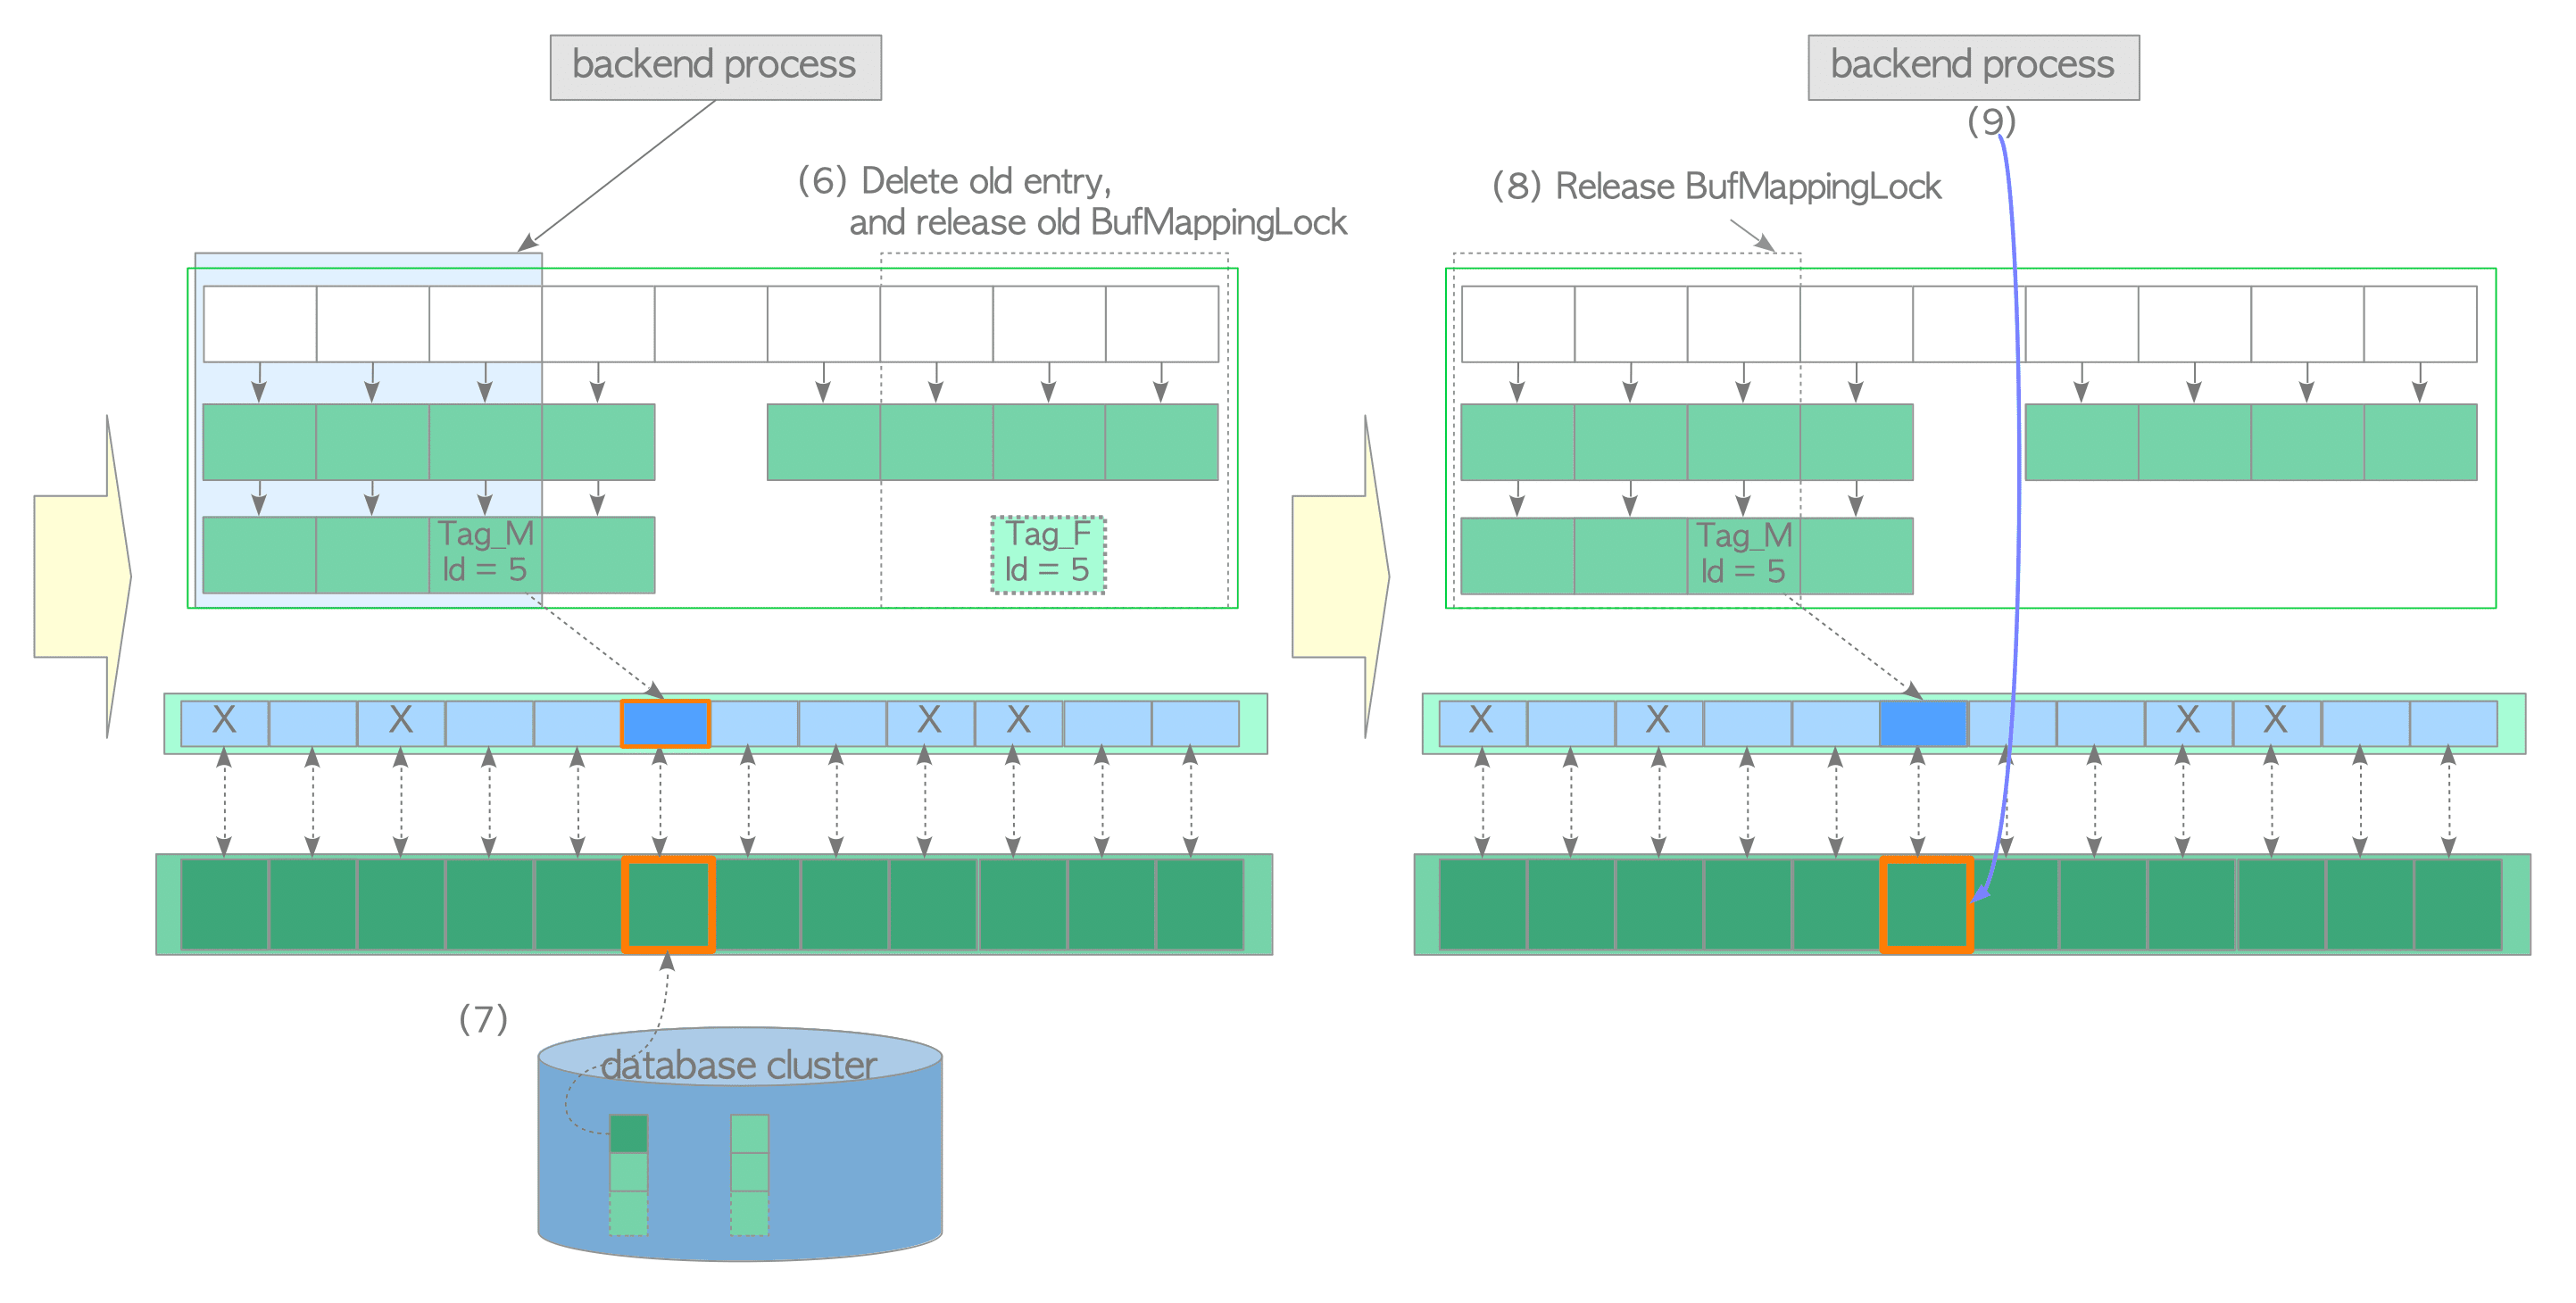

# **Page Replacement Algorithm: Clock Sweep**

- 이 섹션의 나머지 부분에서는 클럭 스윕 알고리즘에 대해 설명.
- 이 알고리즘은 오버헤드가 낮은 NFU(Not잦은 사용)의 변형.
- 덜 자주 사용되는 페이지를 효율적으로 선택.

- 부호 없는 32비트 정수인 nextVictimBuffer는 항상 버퍼 설명자 중 하나를 가리키며 시계 방향으로 회전.

**Pseudocode: clock-sweep**



```
    WHILE true
(1)    Obtain the candidate buffer descriptor pointed by the nextVictimBuffer
(2)    IF the candidate descriptor is 'unpinned' THEN
(3)       IF the candidate descriptor's usage_count == 0 THEN
             BREAK WHILE LOOP  /* the corresponding slot of this descriptor */
                               /* is victim slot.                           */
          ELSE
             Decrease the candidate descriptpor's usage_count by 1
          END IF
       END IF
(4)    Advance nextVictimBuffer to the next one
    END WHILE
(5) RETURN buffer_id of the victim
```

1. nextVictimBuffer가 가리키는 후보 버퍼 디스크립터를 획득.
2. 후보 버퍼 디스크립터가 고정 해제된 경우 (3)단계로 진행.
  - 그렇지 않으면 (4)단계로 진행.
3. Candidate descriptor의 Usage_count가 0인 경우, 이 Descriptor의 해당 슬롯을 희생자로 선택하고 (5)단계로 진행.
  - 그렇지 않으면 이 설명자의 Usage_count를 1만큼 줄이고 단계 (4)로 진행.
4. nextVictimBuffer를 다음 설명자로 진행하고(끝에 있으면 랩 어라운드) 단계 (1)로 돌아감.
  - victim을 찾을 때까지 반복.
5. victim 의 buffer_id를 반환.

- 버퍼 설명자는 파란색 또는 청록색 상자로 표시되며 상자의 숫자는 각 설명자의 Usage_count를 나타냄.

**Clock Sweep.**

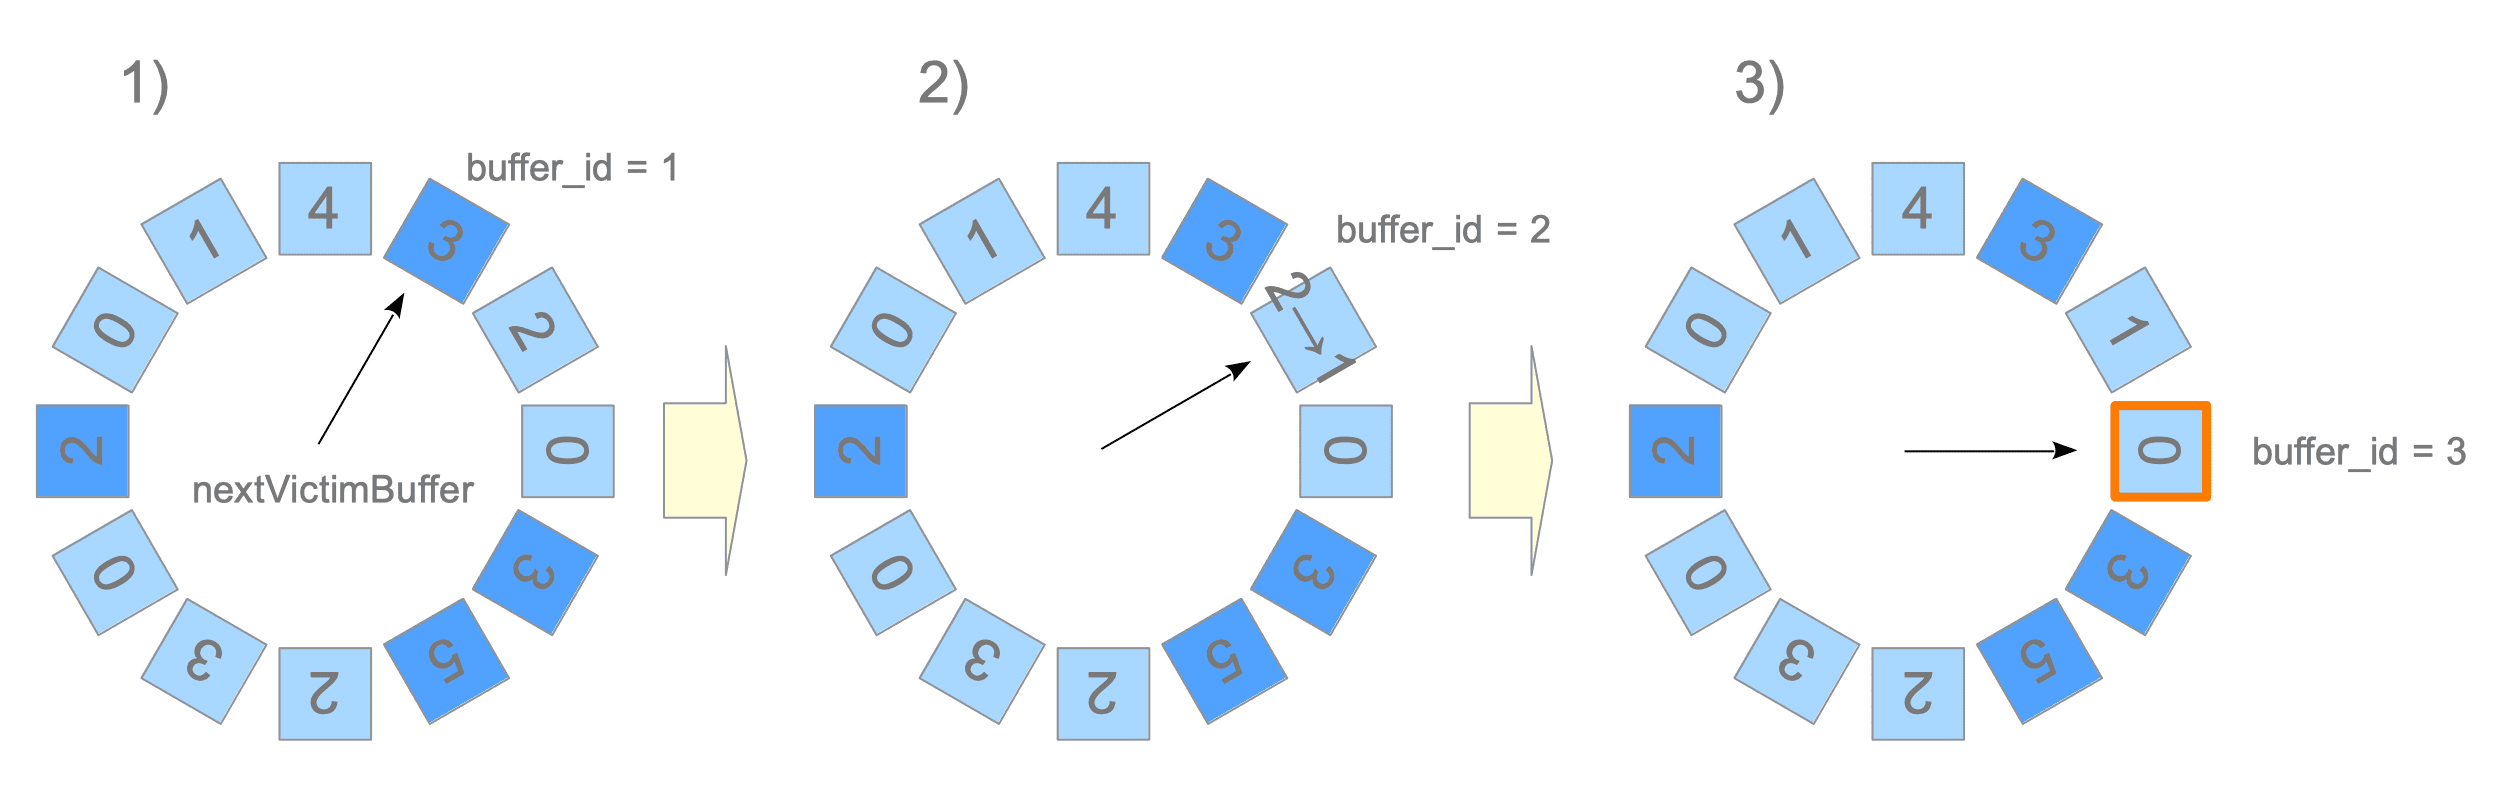

1. nextVictimBuffer는 첫 번째 설명자(buffer_id 1)를 가리킴.
  - 그러나 이 설명자는 고정되어 있으므로 건너뜀.

2. nextVictimBuffer는 두 번째 설명자(buffer_id 2)를 가리킴.
  - 이 설명자는 고정 해제되었지만 Usage_count는 2.
  - 따라서 Usage_count는 1만큼 감소하고 nextVictimBuffer는 세 번째 후보로 이동.

3. nextVictimBuffer는 세 번째 설명자(buffer_id 3)를 가리킴.
  - 이 설명자는 고정 해제되었으며 Usage_count는 0.
  - 따라서 이번 라운드의 victim은 바로 이 사람.

- nextVictimBuffer가 고정되지 않은 설명자를 스윕할 때마다 해당 Usage_count는 1씩 감소.
- 따라서 고정되지 않은 설명자가 버퍼 풀에 존재하는 경우 이 알고리즘은 nextVictimBuffer를 회전하여 항상 Usage_count가 0인 피해자를 찾을 수 있음.